# Part 1: Serra's Analysis
In this notebook we demonstrate our implementation of Serra's Sine Plus Noise analysis.

**Set the paths below to point to the directories of the Philharmonia Cello and Guitar samples.**

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pathlib import Path
CELLO_PATH  = Path("/home/lukas/BA/philharmonia-samples/cello")
GUITAR_PATH = Path("/home/lukas/BA/philharmonia-samples/guitar")

# Output directories for figures and wavfiles
GFX_PATH    = Path("/tmp/gfx")
WAVS_PATH   = Path("/tmp/wavs")

# Whether to rebuild the dataset (The dataset needs to be built
# at least once. Building from the commandline seems to be
# significantly faster than from Jupyter, though I don't know why.
# So I advise to set this to False and build from the commandline
# instead.)
REBUILD_DATASETS = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%%capture

import pya
aserver = pya.Aserver()
aserver.boot()
pya.Aserver.default = aserver

In [6]:
# Initialization
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import principal_harmonics as ph

for path in [GFX_PATH, WAVS_PATH]:
    if path.exists() and not path.is_dir():
        raise NotADirectoryError(path)
    if not path.exists():
        path.mkdir()

# Pitch estimation
The YIN Pitch tracker provides reliable pitch estimates for loud parts of the
signal. For quiter parts, the estimation tends to jump - this is especially 
problematic for the guitar, where the signal decays rapidly.

* Use `principal_harmonics.pvoc.get_pitch()` to get the YIN pitch estimate
  of a signal
* Use `principal_harmonics.pvoc.constant_pitch()` to get a weighted-median 
  estimate of a constant pitch given a time-varying pitch estimate and an
  expected frequency.

In [7]:
cello_path  = CELLO_PATH / 'cello_A4_15_forte_arco-normal.mp3'
guitar_path = GUITAR_PATH / 'guitar_A4_very-long_forte_normal.mp3'
cello_asig  = pya.Asig(str(cello_path))
guitar_asig = pya.Asig(str(guitar_path))
cello_pitch  = ph.pvoc.get_pitch(cello_asig)
guitar_pitch = ph.pvoc.get_pitch(guitar_asig)
constant_guitar_pitch = ph.pvoc.constant_pitch(guitar_pitch, expected=440.0)

ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


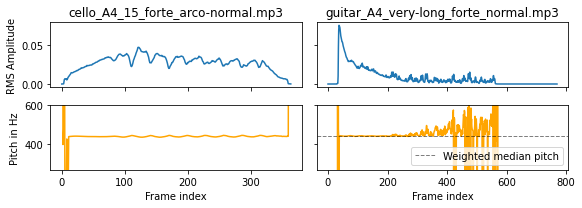

In [8]:
fig, ((cello_rms_ax, guitar_rms_ax), (cello_pitch_ax, guitar_pitch_ax)) = \
    plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(8.2, 3))

plt.sca(cello_rms_ax)
cello_asig.window_op(fn='rms', nperseg=512, stride=256).plot(x_as_time=False, label='RMS amplitude')
cello_rms_ax.set_ylabel("RMS Amplitude")
cello_rms_ax.set_title(cello_path.name)

cello_pitch_ax.plot(cello_pitch, label='YIN pitch estimation', c='orange')
cello_pitch_ax.set_ylabel("Pitch in Hz")
cello_pitch_ax.set_ylim(270, 600)
cello_pitch_ax.set_xlabel("Frame index")

plt.sca(guitar_rms_ax)
guitar_asig.window_op(fn='rms', nperseg=512, stride=256).plot(x_as_time=False, label='RMS amplitude')
guitar_rms_ax.set_title(guitar_path.name)

guitar_pitch_ax.plot(guitar_pitch,  c='orange')
guitar_pitch_ax.set_xlabel("Frame index")
guitar_pitch_ax.axhline(constant_guitar_pitch, linestyle='--', linewidth=1, c='black', label='Weighted median pitch', alpha=0.5)
guitar_pitch_ax.legend(loc=4)

fig.tight_layout()

plt.savefig(GFX_PATH / '1-pitch-estimation.eps')

# Sinusoidal analysis
Let us analyze a single sample using the sinusoidal analysis. We visualize 
the timbre vectors in two different ways: 

_Plotting the detected peak frequencies vs. time._ The color denotes the
decibel-scaled amplitude of the peak. This can give a holistic view
of the structure of the deterministic component we extracted, including
vibrato, jumping partials, missing values, etc. We can use this to
judge the overall performance of the analysis and to tune analysis parameters
to the data at hand. However, we cannot identify finer structures in the
trajectory of the peak amplitudes.
_Plotting (a subset) of the detected peak amplitudes vs time_,
we can better observe the behaviour of the overtone amplitudes.

In [9]:
# using simple peak matching (default)
cello_pitch = ph.pvoc.get_pitch(cello_asig)
cello_freqs, cello_coefs = ph.pvoc.sinusoidal_analysis(cello_asig, cello_pitch)
start, stop = ph.pvoc.ClipStationary().clip(cello_coefs)
cello_freqs, cello_coefs = cello_freqs[start:stop], cello_coefs[start:stop]

cello_asig_clipped = cello_asig[start*256:stop*256] # we'll need this for later...

# ... and using tracking peak matching
cello_freqs_tracking, cello_coefs_tracking = ph.pvoc.sinusoidal_analysis(cello_asig, cello_pitch, peak_matching='tracking')
cello_freqs_tracking, cello_coefs_tracking = cello_freqs_tracking[start:stop], cello_coefs_tracking[start:stop]

# using simple peak matching (default)
guitar_pitch = ph.pvoc.constant_pitch(ph.pvoc.get_pitch(guitar_asig), expected=440.0)
guitar_freqs, guitar_coefs = ph.pvoc.sinusoidal_analysis(guitar_asig, guitar_pitch)
start, stop = ph.pvoc.ClipTransient().clip(guitar_coefs)
guitar_freqs, guitar_coefs = guitar_freqs[start:stop], guitar_coefs[start:stop]


/home/lukas/miniconda3/envs/ba-venv/lib/python3.9/site-packages/pya/helper/helpers.py:55: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(amp)


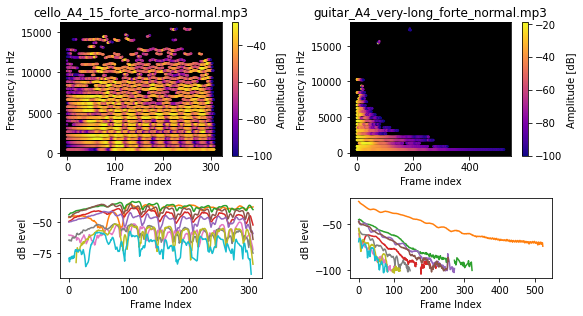

In [10]:
fig = plt.figure(figsize=(8.2, 4.5))

gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[0.5, 0.3])
ax = fig.add_subplot(gs[0,0])
plt.sca(ax)
plt.title(cello_path.name)
ph.plots.plot_timbre_vectors(cello_freqs, cello_coefs)

ax = fig.add_subplot(gs[0,1])
plt.sca(ax)
plt.title(guitar_path.name)
ph.plots.plot_timbre_vectors(guitar_freqs, guitar_coefs)

ax = fig.add_subplot(gs[1,0])
plt.sca(ax)
ph.plots.plot_ampls(np.abs(cello_coefs[:, :10]), dbify=True, write_numbers=False)
plt.xlabel("Frame Index")
ax = fig.add_subplot(gs[1,1])
plt.sca(ax)
ph.plots.plot_ampls(np.abs(guitar_coefs[:, :10]), dbify=True, write_numbers=False)
plt.xlabel("Frame Index")

plt.tight_layout()
plt.savefig(GFX_PATH / '1-timbre-vectors.png', dpi=300)

Comparing the performance of the simple and tracking peak matchers, we see little difference in extracted amplitude.

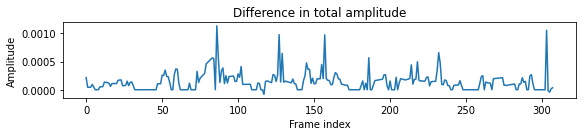

In [11]:
plt.figure(figsize=(8.2, 2))
plt.title("Difference in total amplitude")
plt.xlabel("Frame index")
plt.ylabel("Amplitude")
cello_ampls_simple   = np.nansum(np.abs(cello_coefs), axis=1)
cello_ampls_tracking = np.nansum(np.abs(cello_coefs_tracking), axis=1)
plt.plot(cello_ampls_simple - cello_ampls_tracking)

plt.tight_layout()
plt.savefig(GFX_PATH / "1-peak-matching-eval.eps")

We can analyze the inner workings of the analysis by having it return the spectrum computation for each frame...

In [12]:
freqs, coefs, steps = ph.pvoc.sinusoidal_analysis(cello_asig, cello_pitch, return_steps=True)
step = steps[42]

ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


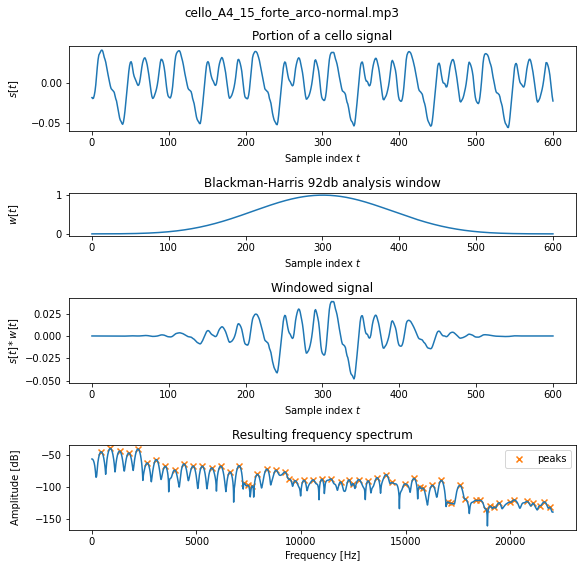

In [13]:
%matplotlib inline
import scipy.signal
import matplotlib.gridspec

fig = plt.figure(figsize=(8.2, 8))
gs = matplotlib.gridspec.GridSpec(4, 1, height_ratios=[1,0.5,1,1])
plt.suptitle(cello_path.name)

ax = fig.add_subplot(gs[0, 0])
step.asig_slice.plot(x_as_time=False, ax=ax)
ax.set_title("Portion of a cello signal")
ax.set_xlabel("Sample index $t$")
ax.set_ylabel("$s[t]$")

ax = fig.add_subplot(gs[1, 0])
win = scipy.signal.get_window('blackmanharris', step.asig_slice.samples)
ax.plot(win)
ax.set_title("Blackman-Harris 92db analysis window")
ax.set_xlabel("Sample index $t$")
ax.set_ylabel("$w[t]$")

ax = fig.add_subplot(gs[2, 0])
(step.asig_slice * win).plot(x_as_time=False, ax=ax)
ax.set_title("Windowed signal")
ax.set_xlabel("Sample index $t$")
ax.set_ylabel("$s[t] * w[t]$")

ax = fig.add_subplot(gs[3, 0])
fft_freqs = step.fft_freqs
fft_dbs   = pya.ampdb(np.abs(step.fft_coefs))
ax.plot(step.fft_freqs, fft_dbs)

maxs = scipy.signal.argrelmax(fft_dbs)
ax.scatter(fft_freqs[maxs], fft_dbs[maxs], marker='x', label='peaks', color='tab:orange')

ax.set_ylabel("Amplitude [dB]")
ax.set_xlabel("Frequency [Hz]")
ax.legend()
ax.set_title("Resulting frequency spectrum")

fig.align_ylabels()
plt.tight_layout()

plt.savefig(GFX_PATH / "1-spectrum.eps")

This figure illustrates the simple peak matcher. (Not used in the report)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


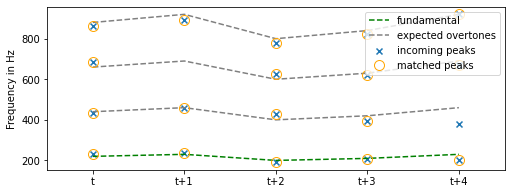

In [14]:
import matplotlib.gridspec as gridspec
import matplotlib.image as img
rng = np.random.default_rng(seed=42)

plt.figure(figsize=(8.2, 3))
fundamentals   = np.array([220, 230, 200, 210, 230])
n              = fundamentals.shape[0]
ks             = np.arange(1, 5).reshape((1, -1))
m              = ks.shape[1]
expected_freqs = fundamentals.reshape((-1, 1)) * ks
devs            = np.random.uniform(-30, 30, size=expected_freqs.shape)
devs[1, 2] = np.nan
devs[4, 1] = -80
actual_freqs   = expected_freqs + devs 

xs = np.broadcast_to(np.arange(n).reshape((-1, 1)), actual_freqs.shape)

plt.ylabel("Frequency in Hz")
plt.xlim(-0.5, n - 0.5)
plt.xticks(np.arange(n), labels=['t', 't+1', 't+2', 't+3', 't+4'])

plt.plot(np.arange(n), fundamentals, label='fundamental', c='green', linestyle='--')
for i in range(1, m):
    line = plt.plot(xs[:, i], expected_freqs[:, i],  c='gray', linestyle='--')[0]
    if i == 1:
        line.set_label('expected overtones')

plt.scatter(xs.ravel(), actual_freqs.ravel(), label='incoming peaks', marker='x')
matches = np.where(np.abs(expected_freqs - actual_freqs) < 30)
plt.plot(xs[matches].ravel(), actual_freqs[matches].ravel(), c='orange', marker='o', markersize=10, label='matched peaks', fillstyle='none', linestyle='none',)

plt.legend(loc=1)
plt.savefig(GFX_PATH / '1-expected-overtone-peak-matcher.eps')

Having gathered timbre vectors, let's check that the resynthesis worked:

In [15]:
resynth = ph.pvoc.phase_correct_resynth(cello_freqs, cello_coefs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


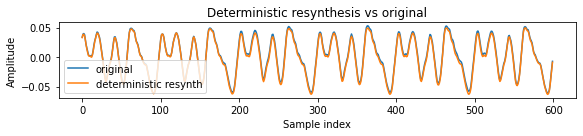

In [16]:
plt.figure(figsize=(8.2, 2))
plt.title("Deterministic resynthesis vs original")
plt.ylabel("Amplitude")
t = 42*256
n = int((6*step.n_samples)//2)
cello_asig_clipped[t-n : t+n].plot(label='original', x_as_time=False)
resynth[t-n:t+n].plot(label='deterministic resynth', x_as_time=False)
plt.xlabel("Sample index")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig(GFX_PATH / '1-phase-correct-resynth.eps')

We can subtract the synthesized signal from the original to get the stochastic residue.

In [28]:
guitar_freqs_tracking, guitar_coefs_tracking = ph.pvoc.sinusoidal_analysis(guitar_asig, guitar_pitch, peak_matching='simple')
guitar_resynth = ph.pvoc.phase_correct_resynth(guitar_freqs_tracking, guitar_coefs_tracking)
(guitar_resynth.x - guitar_asig.x).play()

Asig('_subtracted'): 1 x 197120 @ 44100Hz = 4.470s cn=['0']

Using plain additive synthesis without considering the phases, we get a signal that is perceptually the same.

In [18]:
guitar_resynth_additive = ph.pvoc.additive_resynth(guitar_freqs_tracking, np.abs(guitar_coefs_tracking))
guitar_resynth_additive.play()

(1, 1) (770, 40) (770, 40)


ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred


Asig(''): 1 x 196864 @ 44100Hz = 4.464s cn=['0']

# Building the dataset
Having looked at the analysis of single samples, let us now build the whole
dataset. If `REBUILD_DATASET` was set to True, this might take a while.

In [19]:
if REBUILD_DATASETS:
    for path in [CELLO_PATH, GUITAR_PATH]:
        # delete labels file if it exists
        if (path / 'labels.csv').exists():
            (path / 'labels.csv').unlink()
    ph.dataset.build_labels(base_dir=CELLO_PATH,  glob='cello_*_15_*_arco-normal.mp3', parser='philharmonia')
    ph.dataset.build_labels(base_dir=GUITAR_PATH, glob='guitar_*_very-long_*_normal.mp3', parser='philharmonia')
    
    ph.dataset.build_dataset(GUITAR_PATH, pitch_mode='constant', clip_strategy='transient')
    ph.dataset.build_dataset(CELLO_PATH,  pitch_mode='variable', clip_strategy='stationary')

We can load the whole dataset from disk using `ph.dataset.open_dataset`. The
dataframe that is returned contains all analysis results and the labels.
Frequencies and Coefficients are stored as np.ndarray _objects_, i.e. they need
to be unwrapped before they can be used for analysis in a pandas Series. This is
because the analysis results might not have the same dimensionality (the stochastic
analysis might have a different hop size than the deterministic analysis))

In [20]:
cello_df  = ph.dataset.open_dataset(CELLO_PATH)
guitar_df = ph.dataset.open_dataset(GUITAR_PATH)
pd.options.display.min_rows=30
pd.options.display.max_rows=30
cello_df

ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8545:(snd_pcm_recover) underrun occurred


,Unnamed: 0,midi,exclude,other,instrument,duration,dynamic,note,clipped_wav,resynth_wav,noise_wav,freqs,coefs,clip_start,clip_end,harmonic_r2
filename,,,,,,,,,,,,,,,,
cello_A2_15_forte_arco-normal.mp3,0,45.0,False,arco-normal,cello,15,forte,A2,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 104.13755830589717, 220.59828873285548,...","[[(nan+0j), (-0.0397072106711748-0.01205343835...",2560,89600,0.995882
cello_A2_15_pianissimo_arco-normal.mp3,1,45.0,False,arco-normal,cello,15,pianissimo,A2,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 109.08368268621258, 225.84248159224737,...","[[(nan+0j), (-0.023348964511153345-0.041663529...",6912,97024,0.986853
cello_A2_15_piano_arco-normal.mp3,2,45.0,False,arco-normal,cello,15,piano,A2,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 107.51211954037203, 221.4914384292919, ...","[[(nan+0j), (0.04739148378747499+0.01563170474...",6656,87552,0.993044
cello_A3_15_forte_arco-normal.mp3,3,57.0,False,arco-normal,cello,15,forte,A3,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, nan, 439.82530391989735, 664.3351578249...","[[(nan+0j), (nan+0j), (0.08450270399437952+0.0...",2304,90624,0.989918
cello_A3_15_mezzo-piano_arco-normal.mp3,4,57.0,False,arco-normal,cello,15,mezzo-piano,A3,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 221.3692305418352, 443.50368934002137, ...","[[(nan+0j), (-0.02755617147885274+0.0051095704...",2304,75008,0.991400
cello_A4_15_forte_arco-normal.mp3,5,69.0,False,arco-normal,cello,15,forte,A4,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 435.0358103440204, 883.5633138121162, 1...","[[(nan+0j), (0.010365482032602479+0.0509657894...",4864,83712,0.992536
cello_A4_15_mezzo-piano_arco-normal.mp3,6,69.0,False,arco-normal,cello,15,mezzo-piano,A4,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 443.09561400444176, 881.5015898298287, ...","[[(nan+0j), (-0.05139194407798083+0.0320984925...",5120,96768,0.974914
cello_A5_15_forte_arco-normal.mp3,7,81.0,False,arco-normal,cello,15,forte,A5,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 889.5687465509048, 1776.7517534902554, ...","[[(nan+0j), (0.06828385219880248-0.05323391754...",7936,84992,0.993782
cello_A5_15_mezzo-piano_arco-normal.mp3,8,81.0,False,arco-normal,cello,15,mezzo-piano,A5,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,/home/lukas/BA/philharmonia-samples/cello/cell...,"[[nan, 881.4885420990973, 1776.082857731659, 2...","[[(nan+0j), (-0.06442965915657412-0.0644412294...",5632,93440,0.979005


We can unwrap ndarrays by using `ph.dataset.expand_ndarrays()`, yielding a `MultiIndex`ed dataframe:

In [21]:
ph.dataset.expand_ndarrays(cello_df, ['freqs', 'coefs'])

freqs-0     freqs-1      freqs-2  \
filename                                n                                       
cello_A2_15_forte_arco-normal.mp3       0        NaN  104.137558   220.598289   
                                        1        NaN  104.147027   216.604819   
                                        2        NaN  104.319988   215.776632   
                                        3        NaN  104.724961   215.664823   
                                        4        NaN  105.260677   216.328448   
                                        5        NaN  105.572623   217.762039   
                                        6        NaN  105.823635   219.582341   
                                        7        NaN  106.518020   220.518023   
                                        8        NaN  107.561063   220.101268   
                                        9        NaN  108.587171   219.288079   
                                        10       NaN  109.621103   218.927402   
                                        11       NaN  110.476806   218.887618   
                                        12       NaN  110.710476   218.861005   
                                        13       NaN  110.205722   218.821524   
                                        14       NaN  109.388313   218.787805   
...                                              ...         ...          ...   
cello_Gs5_15_pianissimo_arco-normal.mp3 224      NaN  826.871125  1674.464250   
                                        225      NaN  827.197457  1660.688193   
                                        226      NaN  828.207768  1654.150380   
                                        227      NaN  827.432263  1655.191645   
                                        228      NaN  829.678140  1650.765588   
                                        229      NaN  829.861801  1658.678979   
                                        230      NaN  832.514302  1668.432379   
                                        231      NaN  830.266029  1660.239430   
                                        232      NaN  832.361679  1670.256452   
                                        233      NaN  832.177705  1664.896523   
                                        234      NaN  832.599091  1672.435802   
                                        235      NaN  830.661842  1666.078569   
                                        236      NaN  832.651638  1661.470263   
                                        237      NaN  828.948936  1660.014666   
                                        238      NaN  828.786480  1655.368995   

                                                freqs-3      freqs-4  \
filename                                n                              
cello_A2_15_forte_arco-normal.mp3       0    318.077413          NaN   
                                        1    319.800956          NaN   
                                        2    321.678334          NaN   
                                        3    323.746908   442.430948   
                                        4    325.791948   440.828898   
                                        5    327.478049   439.372924   
                                        6    328.353235   439.457084   
                                        7    328.042049   441.372627   
                                        8    326.858993   442.859676   
                                        9    325.775657   441.748662   
                                        10   325.263526   439.400788   
                                        11   325.374477   438.485908   
                                        12   325.714377   439.259736   
                                        13   325.838015   440.156431   
                                        14   325.903406   440.237244   
...                                                 ...          ...   
cello_Gs5_15_pianissimo_arco-normal.mp3 224         NaN  3329.788233   
   

Let's look at the results for the cello. Notice that the r2 scores are degraded only for C2, C#2, D2 notes.

In [22]:
cello_df.sort_values('harmonic_r2')[['note', 'harmonic_r2']]

,note,harmonic_r2
filename,,
cello_Cs2_15_fortissimo_arco-normal.mp3,C♯2,0.000184
cello_Cs2_15_piano_arco-normal.mp3,C♯2,0.000417
cello_Cs2_15_forte_arco-normal.mp3,C♯2,0.000643
cello_C2_15_piano_arco-normal.mp3,C2,0.021169
cello_D2_15_pianissimo_arco-normal.mp3,D2,0.022226
cello_C2_15_forte_arco-normal.mp3,C2,0.109291
cello_D2_15_mezzo-piano_arco-normal.mp3,D2,0.116769
cello_D2_15_forte_arco-normal.mp3,D2,0.151544
cello_Cs2_15_pianissimo_arco-normal.mp3,C♯2,0.167291


The guitar shows worse R2 results. However, notice that the samples with the worst R2 scores are almost all `piano` samples,
and the samples with the best scores are almost all `forte` samples.

In [23]:
guitar_df.sort_values('harmonic_r2')[['note', 'harmonic_r2']]

,note,harmonic_r2
filename,,
guitar_E5_very-long_piano_normal.mp3,E5,0.198769
guitar_E2_very-long_piano_normal.mp3,E2,0.239426
guitar_Ds5_very-long_piano_normal.mp3,D♯5,0.249378
guitar_Gs5_very-long_forte_normal.mp3,G♯5,0.268161
guitar_C3_very-long_piano_normal.mp3,C3,0.312250
guitar_F3_very-long_piano_normal.mp3,F3,0.322729
guitar_E3_very-long_piano_normal.mp3,E3,0.336654
guitar_G4_very-long_piano_normal.mp3,G4,0.395874
guitar_Cs3_very-long_piano_normal.mp3,C♯3,0.405350


If we interpret the dynamic as `piano` == 0 and `forte` == 1, we get a 0.52 corellation between the dynamic and the r2 score.

In [24]:
guitar_df['dynamic_int'] = guitar_df.dynamic.apply(lambda d: 1.0 if d == 'forte' else 0)
guitar_df.convert_dtypes()[['dynamic_int', 'harmonic_r2']].corr()

,dynamic_int,harmonic_r2
dynamic_int,1.000000,0.518304
harmonic_r2,0.518304,1.000000


Let's build all stats for the report:

In [25]:
import librosa

quantiles = [0, 0.25, 0.5, 0.75, 1]
cello_r2s         = cello_df.harmonic_r2.quantile(quantiles)
cello_over_d2_r2s = cello_df[cello_df.midi > librosa.note_to_midi('D2')].harmonic_r2.quantile(quantiles)

guitar_r2s       = guitar_df.harmonic_r2.quantile(quantiles)
guitar_piano_r2s = guitar_df[guitar_df.dynamic == 'piano'].harmonic_r2.quantile(quantiles)
guitar_forte_r2s = guitar_df[guitar_df.dynamic == 'forte'].harmonic_r2.quantile(quantiles)

r2_stats = pd.DataFrame(
    [  
        cello_r2s,
        cello_over_d2_r2s,
        guitar_r2s,
        guitar_piano_r2s,
        guitar_forte_r2s
    ], 
    index=['Cello', 
           '  Cello > D2', 
           'Guitar', 
           r'  Guitar \textbf{\textit{p}}',
           r'  Guitar \textbf{\textit{f}}']
)
r2_stats.columns = [r'\(q=0\) (min)', r'\(q=0.25\)', r'\(q=0.5\) (median)', 
                    r'\(q=0.75\)', r'\(q=1\) (max)']
r2_stats

,\(q=0\) (min),\(q=0.25\),\(q=0.5\) (median),\(q=0.75\),\(q=1\) (max)
Cello,0.000184,0.978829,0.991228,0.996171,0.999061
Cello > D2,0.794196,0.983347,0.992441,0.996351,0.999061
Guitar,0.198769,0.549556,0.761197,0.865428,0.958670
Guitar \textbf{\textit{p}},0.198769,0.446254,0.606756,0.751304,0.928321
Guitar \textbf{\textit{f}},0.268161,0.772095,0.856637,0.900786,0.958670


In [26]:
r2_stats.style.to_latex(GFX_PATH / '1-r2-stats.tex', hrules=True,
                        label='tab:r2-stats', 
                        caption=r'\(R^2\) scores of the deterministic synthesis, in quantiles.',
                        position_float='centering')

Copying the analysis results that are referenced in the report...

In [27]:
def write_results(df, fname):
    asig = pya.Asig(str(df.loc[fname + '.mp3'].clipped_wav))
    asig.save_wavfile(str(WAVS_PATH / ('ch3_' + fname + '_clipped.wav')))
    asig = pya.Asig(str(df.loc[fname + '.mp3'].resynth_wav))
    asig.save_wavfile(str(WAVS_PATH / ('ch3_' + fname + '_harmonic-analysis.wav')))
    asig = pya.Asig(str(df.loc[fname + '.mp3'].noise_wav))
    asig.save_wavfile(str(WAVS_PATH / ('ch3_' + fname + '_noise-residue.wav')))

for fname in [
    "cello_A4_15_forte_arco-normal",
    "cello_Cs3_15_fortissimo_arco-normal",
    "cello_Cs3_15_pianissimo_arco-normal", 
    "cello_E4_15_mezzo-piano_arco-normal", 
]:
    write_results(cello_df, fname)

for fname in [
    "guitar_As4_very-long_forte_normal", 
    "guitar_Ds3_very-long_piano_normal"
]:
    write_results(guitar_df, fname)
